In [ ]:
#
# Practical 3.2 - Language Model with RNNs
#

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from tqdm import tqdm
from pprint import pprint

from lib.data import (
    batch_pad_truncate_dataset,
    load_TED_dataset,
    drop_data_of_label,
)
from lib.text import (
    build_encoder_decoder_from_vocab,
    get_top_frequent_words,
    parse_text_to_tokenised_sentences,
)
from lib.plot import plot_frequency_map
from lib.model import train_evaluate_model

In [3]:
def output_logits_to_sample(output_logits):
    output_sample_tensor = tf.random.categorical(output_logits, num_samples=1)
    output_sample = tf.squeeze(output_sample_tensor, axis=-1).numpy()
    return output_sample


def print_output_sample(output_sample, input_sample, decoder, input_char=False):
    joiner = "" if input_char else " "
    print(f"input:\n{joiner.join([decoder[encoded] for encoded in input_sample])}")
    print()
    print(f"output:\n{joiner.join([decoder[encoded] for encoded in output_sample])}")
    print()


def show_correctness(input_sample, output_sample):
    correct = 0
    for i, encoded in enumerate(input_sample):
        if encoded == output_sample[i]:
            correct += 1
    print(
        f"correctness: {correct}/{len(output_sample)}={correct/len(output_sample):.2f}"
    )


def batch_sample_model_output(model, decoder, batch_input, input_char=False):
    batch_output = model(batch_input)
    output_logits = batch_output[0]
    input_sample = batch_input[0]
    output_sample = output_logits_to_sample(output_logits)
    print_output_sample(output_sample, input_sample, decoder, input_char)
    show_correctness(
        [encoded for input_sample in batch_input for encoded in input_sample],
        output_logits_to_sample(
            [logits for output_sample in batch_output for logits in output_sample]
        ),
    )

In [5]:
class Perplexity(tf.keras.metrics.Metric):
    """
    USAGE NOTICE: this metric accepts only logits
    i.e. expect the same behaviour as tf.keras.losses.SparseCategoricalCrossentropy 
    with "from_logits=True", here the same loss is used with "from_logits=True" 
    enforced so you need to provide it in such a format.
    """

    def __init__(self, name="perplexity", **kwargs):
        super(Perplexity, self).__init__(name=name, **kwargs)
        self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction="none"
        )
        self.perplexity = self.add_weight(name="tp", initializer="zeros")

    def _calculate_perplexity(self, real, pred):
        loss = self.cross_entropy(real, pred)
        K = tf.keras.backend  # Alias to Keras' backend namespace.
        step1 = K.mean(loss, axis=-1) # get the mean cross-entropy of the sequence
        step2 = K.exp(step1) # get the perplexity of each sequence in the batch
        # TODO: examine the implementation of perplexity here
        # has it be normalised by per word for ^1/N?
        perplexity = K.mean(step2) # get the average perplexity of the batch?

        return perplexity

    def update_state(self, y_true, y_pred, sample_weight=None):
        # TODO:FIXME: handle sample_weight !
        if sample_weight is not None:
            print(
                "WARNING! Provided 'sample_weight' argument to the perplexity metric. Currently this is not handled and won't do anything differently.."
            )
        perplexity = self._calculate_perplexity(y_true, y_pred)
        # self.perplexity is a tensor (tf.Variable),
        # so using simply "self.perplexity = perplexity"
        # will result in error because of mixing EagerTensor
        # and Graph operations
        self.perplexity.assign_add(perplexity)

    def result(self):
        return self.perplexity

    def reset_states(self):
        self.perplexity.assign(0.0)

In [6]:
def load_latest_checkpoint(model, checkpoint_name):
    checkpoint_dir = f'./output/training_checkpoints/{checkpoint_name}'
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model.build(tf.TensorShape([1, None]))

In [4]:
#
# hyper parameters
#

EMBEDDING_SIZE = 100
BATCH_SIZE = 100

In [2]:
#
# load data
#

tokenised_content = [parse_text_to_tokenised_sentences(clip) for clip in tqdm(load_TED_dataset())]

ted_en-20160408.zip already downloaded.


100%|██████████| 2085/2085 [00:04<00:00, 499.07it/s]


In [7]:
#
# 0. top words only encoding
#

#
# for examining the effect of corpus on perplexity
#

In [9]:
#
# Build the encoder and decoder from word_frequency_map
#
all_words = [
    word for clip in tokenised_content for sentence in clip for word in sentence
]
top_1000_words = get_top_frequent_words(all_words, 1000)
encoder, decoder = build_encoder_decoder_from_vocab(set(top_1000_words), has_unknown=True)

print(len(encoder))

100%|██████████| 4447611/4447611 [00:01<00:00, 2280602.75it/s]


1004


In [11]:
#
# encode the dataset and split it for training
#


def encode_dataset_with_ends_padding_unknown(tokenised_content, encoder):
    longest_sentence = max(
        [len(sentence) for clip in tokenised_content for sentence in clip]
    )

    output = []

    for clip in tqdm(tokenised_content):
        for sentence in clip:

            encoded_sentence = [
                encoder[word] if word in encoder.keys() else encoder["_UNK_"]
                for word in ["_BOS_", *sentence, "_EOS_"]
            ]

            padded = np.append(
                encoded_sentence, np.zeros(longest_sentence - len(sentence), dtype=int),
            )

            output.append((padded[:-1], padded[1:]))
    return output


encoded_dataset = encode_dataset_with_ends_padding_unknown(tokenised_content, encoder)
print(np.array(encoded_dataset).shape)

100%|██████████| 2085/2085 [00:04<00:00, 423.43it/s]


(269177, 2, 291)


In [31]:
# model feeding padded sentence batches

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(len(encoder), EMBEDDING_SIZE),
        layers.GRU(64, return_sequences=True),
        layers.Dense(len(decoder)),
    ]
)


def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )

model.compile(loss=loss, optimizer="adam", metrics=[Perplexity()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         100400    
_________________________________________________________________
gru (GRU)                    (None, None, 64)          31872     
_________________________________________________________________
dense (Dense)                (None, None, 1004)        65260     
Total params: 197,532
Trainable params: 197,532
Non-trainable params: 0
_________________________________________________________________
None


Train on 193944 samples, validate on 24243 samples
Epoch 1/10
193944/193944 [==============================] - 43s 220us/sample - loss: 0.5930 - perplexity: 19447.1426 - val_loss: 0.4490 - val_perplexity: 403.2134
Epoch 2/10
193944/193944 [==============================] - 41s 212us/sample - loss: 0.4320 - perplexity: 3149.5017 - val_loss: 0.4243 - val_perplexity: 390.7783
Epoch 3/10
193944/193944 [==============================] - 41s 210us/sample - loss: 0.4159 - perplexity: 3085.9309 - val_loss: 0.4140 - val_perplexity: 385.8223
Epoch 4/10
193944/193944 [==============================] - 40s 208us/sample - loss: 0.4075 - perplexity: 3053.3169 - val_loss: 0.4077 - val_perplexity: 382.6894
Epoch 5/10
193944/193944 [==============================] - 40s 207us/sample - loss: 0.4023 - perplexity: 3033.2515 - val_loss: 0.4039 - val_perplexity: 380.7759
Epoch 6/10
193944/193944 [==============================] - 40s 208us/sample - loss: 0.3990 - perplexity: 3020.5537 - val_loss: 0.4014 - v

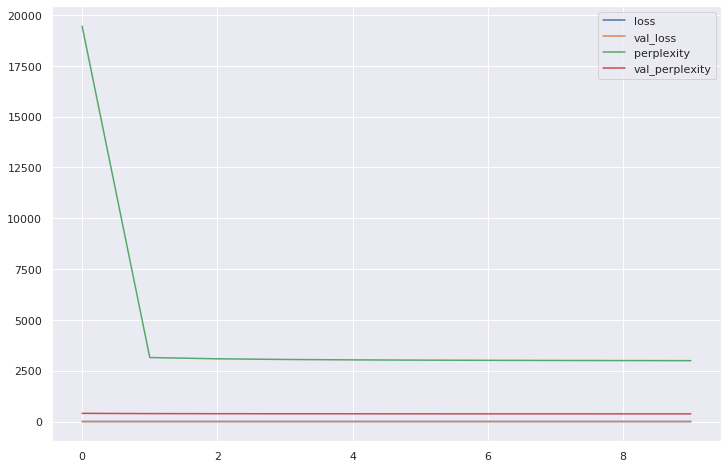

In [32]:
train_evaluate_model(model, encoded_dataset, 'gru_lm_padded_sentence_top_words_encoder')

In [7]:
#
#
#  1. word level encoding
# 
#

In [8]:
# 
# Build Encoder, Decoder
#
vocab = set([word for clip in tokenised_content for sentence in clip for word in sentence])
encoder, decoder = build_encoder_decoder_from_vocab(vocab)

print(len(vocab))
print(len(encoder))
print(len(decoder))
print(encoder['_EOS_'])
print(decoder[len(vocab)+2])

54194
54197
54197
54196
.


In [9]:
#
# 1.1 take i.i.d assumption and encode dataset as padded-sentence-batch
#

In [12]:
def dataset_encoded_with_ends_padding(tokenised_content, encoder):
    longest_sentence = max(
        [len(sentence) for clip in tokenised_content for sentence in clip]
    )

    encoded_padded = [
        np.append(
            [encoder[word] for word in ["_BOS_", *sentence, "_EOS_"]],
            np.zeros(longest_sentence - len(sentence), dtype=int),
        )
        for clip in tqdm(tokenised_content)
        for sentence in clip
    ]

    output = [(clip[:-1], clip[1:]) for clip in encoded_padded]

    return output


encoded_dataset = dataset_encoded_with_ends_padding(tokenised_content, encoder)
print(np.array(encoded_dataset).shape)

100%|██████████| 2085/2085 [00:03<00:00, 562.13it/s]


(269177, 2, 291)


In [37]:
# model feeding padded sentence batches

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(len(encoder), EMBEDDING_SIZE),
        layers.GRU(64, return_sequences=True),
        layers.Dense(len(decoder)),
    ]
)


def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )

model.compile(loss=loss, optimizer="adam", metrics=[Perplexity()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5295400   
_________________________________________________________________
gru (GRU)                    (None, None, 64)          31872     
_________________________________________________________________
dense (Dense)                (None, None, 52954)       3442010   
Total params: 8,769,282
Trainable params: 8,769,282
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
batch_sample_model_output(model, decoder, test_set[0][:1])

input:
 and the point making here is that companies like yours companies like mine have to define purpose which embraces responsibility and understands that we have to play our part in the communities in which we operate . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

output:
derivativeness candies cardiologists convinces 4mm spasmy threads b12 muffin newsletter upwind interconnectivity accords morina zillionaires soap lowbrow sq fed sarnoff brookhouse baxter bunker sansemea outbursts subunits active blender carboxylic beeswax distortions macho windpipes stampedes koshalek hehn shopkeepers propolis infests scours sterilized osteochondral reenactment scuttle impressively alterations pr2 bactarian overbury sterility unprofitable egyptologists decouples vasco cholerae supersize bleakness

Train on 193944 samples, validate on 24243 samples
Epoch 1/10
193944/193944 [==============================] - 584s 3ms/sample - loss: 0.9668 - perplexity: 1105827.3750 - val_loss: 0.6432 - val_perplexity: 524.1665
Epoch 2/10
193944/193944 [==============================] - 588s 3ms/sample - loss: 0.6228 - perplexity: 4121.6382 - val_loss: 0.6094 - val_perplexity: 500.0940
Epoch 3/10
193944/193944 [==============================] - 583s 3ms/sample - loss: 0.5962 - perplexity: 3962.3892 - val_loss: 0.5925 - val_perplexity: 488.5973
Epoch 4/10
193944/193944 [==============================] - 576s 3ms/sample - loss: 0.5790 - perplexity: 3862.1702 - val_loss: 0.5830 - val_perplexity: 482.3410
Epoch 5/10
193944/193944 [==============================] - 574s 3ms/sample - loss: 0.5669 - perplexity: 3792.7888 - val_loss: 0.5766 - val_perplexity: 478.1758
Epoch 6/10
193944/193944 [==============================] - 570s 3ms/sample - loss: 0.5574 - perplexity: 3739.1619 - val_loss: 0.5727 - val_p

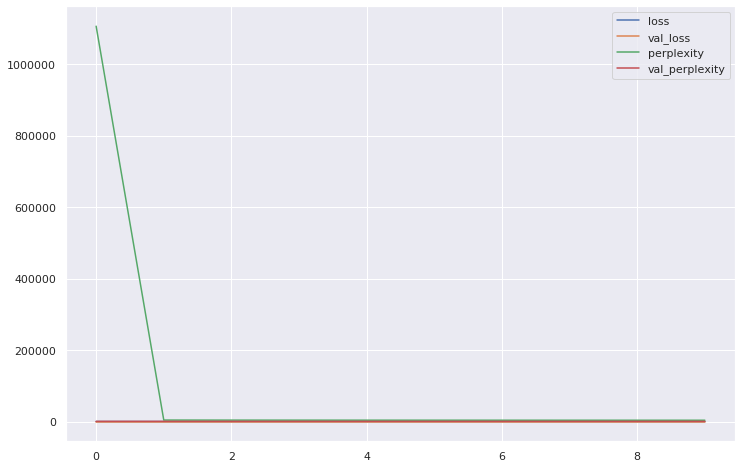

In [38]:
train_evaluate_model(model, encoded_dataset, 'gru_lm_padded_sentence')

In [29]:
load_latest_checkpoint(model, 'gru_lm_padded_sentence')

In [32]:
batch_sample_model_output(model, decoder, test_set[0][:10])

input:
 and holly morgan told me that she used to battle depression until she got involved with effective altruism and now is one of the happiest people she knows . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

output:
gorgonopsian afrikan milner tastes blunck mosul owens polygonal approach garnered tomorrow verified . unum jorgen hates opinion interferer modernization blunck scannable . saabs . stato matere bizarrely statesman unkempt  weathers weathers . . . fruit auschwitz . rumi . . fruit cerf fruit audubon cactus venturi . yawns . blender . meret glider pushup lichtenstein . agglomerate . crochetness aba green majoring nicu . buba activations marksman madame tiber modernization . . incandescent auschwitz isthmus . modernization leatherbound dams . justsaying fruit

In [12]:
# bidirectional GRU model feeding padded sentence batches

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(len(encoder), EMBEDDING_SIZE),
        layers.Bidirectional(
            layers.GRU(64, return_sequences=True), merge_mode="concat"
        ),
        layers.Dense(len(decoder)),
    ]
)


def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )


model.compile(loss=loss, optimizer="adam", metrics=[Perplexity()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5295400   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         63744     
_________________________________________________________________
dense (Dense)                (None, None, 52954)       6831066   
Total params: 12,190,210
Trainable params: 12,190,210
Non-trainable params: 0
_________________________________________________________________
None


Train on 193944 samples, validate on 24243 samples
Epoch 1/10
193944/193944 [==============================] - 697s 4ms/sample - loss: 0.8699 - perplexity: 990411.0625 - val_loss: 0.5784 - val_perplexity: 482.2487
Epoch 2/10
193944/193944 [==============================] - 693s 4ms/sample - loss: 0.4608 - perplexity: 5938.7217 - val_loss: 0.3616 - val_perplexity: 364.6580
Epoch 3/10
193944/193944 [==============================] - 692s 4ms/sample - loss: 0.2759 - perplexity: 3788.5408 - val_loss: 0.2123 - val_perplexity: 306.1549
Epoch 4/10
193944/193944 [==============================] - 688s 4ms/sample - loss: 0.1567 - perplexity: 2295.2393 - val_loss: 0.1298 - val_perplexity: 279.2268
Epoch 5/10
193944/193944 [==============================] - 689s 4ms/sample - loss: 0.0967 - perplexity: 2148.0669 - val_loss: 0.0928 - val_perplexity: 268.1900
Epoch 6/10
193944/193944 [==============================] - 693s 4ms/sample - loss: 0.0640 - perplexity: 2073.8606 - val_loss: 0.0698 - val_pe

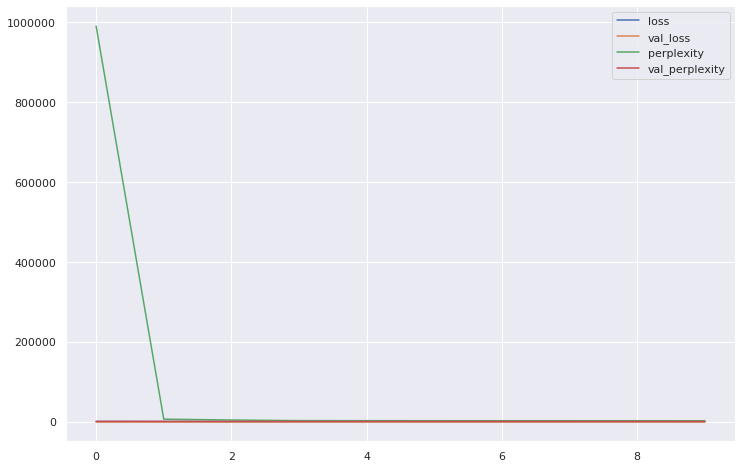

In [13]:
train_evaluate_model(model, encoded_dataset, 'bid_gru_lm_padded_sentence')

In [39]:
#
# 1.2 truncated BPTT - truncated-word-sequence-batch
#

In [14]:
def encode_dataset_padded_clip_batches(
    tokenised_content, encoder, batch_size=100, sequence_length=100
):
    encoded_clips = [
        [encoder[word] for sentence in clip for word in ["_BOS_", *sentence, "_EOS_"]]
        for clip in tqdm(tokenised_content)
    ]

    batch_truncated_encoded_clips = batch_pad_truncate_dataset(
        encoded_clips, 
        batch_size=batch_size, 
        truncate_length=sequence_length+1
    )

    output = [
        (truncated_clip[:-1], truncated_clip[1:])
        for truncated_clip in batch_truncated_encoded_clips
    ]
    
    return output


SEQUENCE_LENGTH = 100
encoded_dataset = encode_dataset_padded_clip_batches(
    tokenised_content, encoder, BATCH_SIZE, SEQUENCE_LENGTH
)
print(np.array(encoded_dataset).shape)

100%|██████████| 20/20 [00:00<00:00, 427.75it/s]


(148000, 2, 100)


In [41]:
# stateful GRU feeding in truncated word sequences

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(
            len(encoder),
            EMBEDDING_SIZE,
            batch_input_shape=[BATCH_SIZE, SEQUENCE_LENGTH],
        ),
        layers.GRU(
            64,
            return_sequences=True,
            stateful=True,
            recurrent_initializer="glorot_uniform",
        ),
        layers.Dense(len(decoder)),
    ]
)


def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )


model.compile(loss=loss, optimizer="adam", metrics=[Perplexity()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, 100, 100)           5295400   
_________________________________________________________________
gru (GRU)                    (100, 100, 64)            31872     
_________________________________________________________________
dense (Dense)                (100, 100, 52954)         3442010   
Total params: 8,769,282
Trainable params: 8,769,282
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
batch_sample_model_output(model, decoder, test_set[0][:BATCH_SIZE])

input:
 to me the real real solution to quality growth is figuring out the balance between two activities exploration and exploitation .  both are necessary but it can be too much of good thing .  actually old enough to remember them .  facit was fantastic company .  they were born deep in the swedish forest and they made the best mechanical calculators in the world .  and what did facit do when the electronic calculator came along .  they continued doing exactly the same .  in six months they went from maximum revenue

output:
chernobyls brethren michael meltdown euvin erupting attribution orgel paranoid gehry mindstorms blinded pharmacists fines jake superorganisms throughout weinmueller armantrout boulders plight deliberation terrible raisins boon sulfur braider muckety skycar endlessly dissolution soaker unfolded fixation biofuel gavin schooled astrophysicist louder horsager crevasses charge brunn flawed comprehend tuner emotive sink carolina overlooks engrafting lawfully conglomer

Train on 105600 samples, validate on 13200 samples
Epoch 1/10
105600/105600 [==============================] - 204s 2ms/sample - loss: 2.6031 - perplexity: 1589889.2500 - val_loss: 1.6880 - val_perplexity: 16150.6855
Epoch 2/10
105600/105600 [==============================] - 203s 2ms/sample - loss: 1.8249 - perplexity: 105787.3359 - val_loss: 1.5864 - val_perplexity: 11585.1348
Epoch 3/10
105600/105600 [==============================] - 203s 2ms/sample - loss: 1.7375 - perplexity: 81129.3594 - val_loss: 1.5389 - val_perplexity: 9890.6299
Epoch 4/10
105600/105600 [==============================] - 203s 2ms/sample - loss: 1.6862 - perplexity: 69222.2344 - val_loss: 1.5103 - val_perplexity: 8981.0127
Epoch 5/10
105600/105600 [==============================] - 203s 2ms/sample - loss: 1.6485 - perplexity: 61528.8867 - val_loss: 1.4915 - val_perplexity: 8454.9980
Epoch 6/10
105600/105600 [==============================] - 203s 2ms/sample - loss: 1.6188 - perplexity: 55934.0586 - val_loss: 1

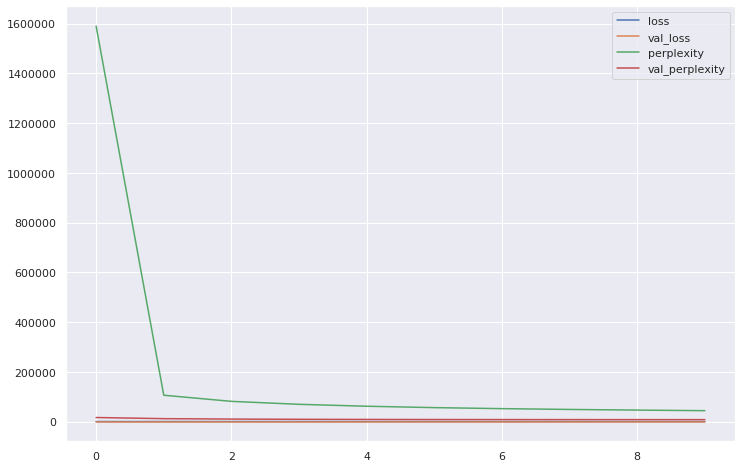

In [42]:
train_evaluate_model(model, encoded_dataset, "truncate_gru_lm", shuffle_dataset=False)

In [38]:
load_latest_checkpoint(model, 'truncate_gru_lm')

In [43]:
batch_sample_model_output(model, decoder, test_set[0][:BATCH_SIZE])

input:
 to me the real real solution to quality growth is figuring out the balance between two activities exploration and exploitation .  both are necessary but it can be too much of good thing .  actually old enough to remember them .  facit was fantastic company .  they were born deep in the swedish forest and they made the best mechanical calculators in the world .  and what did facit do when the electronic calculator came along .  they continued doing exactly the same .  in six months they went from maximum revenue

output:
docs filibustering shaker docs . blackwater zirconium paulus . wrists adultery otters timid weidt fling imminent uncompressed thirtyfold adultery flashy docs  docs peppers nobler twelve wrists adultery deprecating blackwater . simpleton massachusetts weidt 316  serbian otters appendix . balcony assaying flashy  paulus naughty lesterland abraham thirtyfold  paulus pareyio tuba clubs yields otters . scouts 140journos slapped snapchatters sovereigns . . blackwater 

In [13]:
# stateful bidirectional GRU feeding in truncated word sequences

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(
            len(encoder),
            EMBEDDING_SIZE,
            batch_input_shape=[BATCH_SIZE, SEQUENCE_LENGTH],
        ),
        layers.Bidirectional(
            layers.GRU(
                64,
                return_sequences=True,
                stateful=True,
                recurrent_initializer="glorot_uniform",
            ),
            merge_mode="concat",
        ),
        layers.Dense(len(decoder)),
    ]
)


def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )


model.compile(loss=loss, optimizer="adam", metrics=[Perplexity()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, 100, 100)           5295400   
_________________________________________________________________
bidirectional (Bidirectional (100, 100, 128)           63744     
_________________________________________________________________
dense (Dense)                (100, 100, 52954)         6831066   
Total params: 12,190,210
Trainable params: 12,190,210
Non-trainable params: 0
_________________________________________________________________
None


Train on 105600 samples, validate on 13200 samples
Epoch 1/10
105600/105600 [==============================] - 248s 2ms/sample - loss: 2.1696 - perplexity: 1185990.2500 - val_loss: 1.2136 - val_perplexity: 3231.5562
Epoch 2/10
105600/105600 [==============================] - 242s 2ms/sample - loss: 1.0484 - perplexity: 11806.2881 - val_loss: 0.7496 - val_perplexity: 724.1461
Epoch 3/10
105600/105600 [==============================] - 242s 2ms/sample - loss: 0.6541 - perplexity: 3744.2849 - val_loss: 0.5036 - val_perplexity: 352.2283
Epoch 4/10
105600/105600 [==============================] - 241s 2ms/sample - loss: 0.4415 - perplexity: 2200.9336 - val_loss: 0.3744 - val_perplexity: 253.5541
Epoch 5/10
105600/105600 [==============================] - 240s 2ms/sample - loss: 0.3174 - perplexity: 1693.7952 - val_loss: 0.2967 - val_perplexity: 213.0085
Epoch 6/10
105600/105600 [==============================] - 241s 2ms/sample - loss: 0.2365 - perplexity: 1459.5051 - val_loss: 0.2475 - val

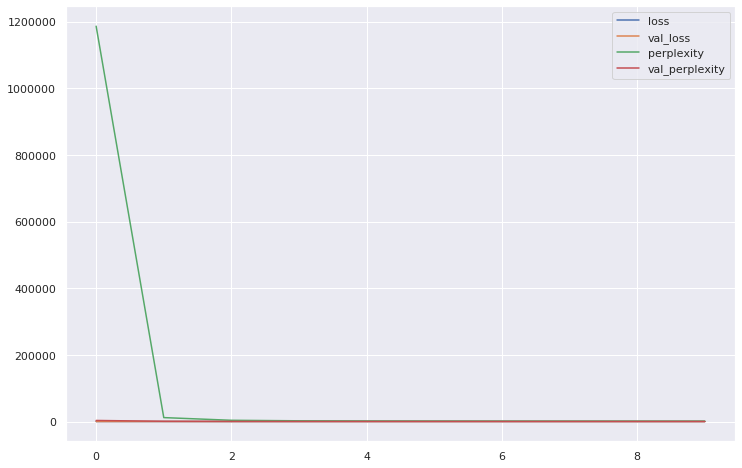

In [14]:
train_evaluate_model(model, encoded_dataset, "truncate_bid_gru_lm", shuffle_dataset=False)

In [8]:
#
#
# 2. character level encoding
#
#

In [9]:
# encoder, decoder
all_words = [word for clip in tokenised_content for sentence in clip for word in sentence]
chars = sorted(set(" ".join(all_words)))
print(chars)

encoder = {
    **{char: i + 1 for i, char in enumerate(chars)},
    "_PAD_": 0,
    "_BOS_": len(chars) + 1,
    "_EOS_": len(chars) + 2,
}
decoder = {
    **{i + 1: char for i, char in enumerate(chars)},
    0: "*",
    len(chars) + 1: "",
    len(chars) + 2: ".",
}
print(encoder)
print(decoder)

[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{' ': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, '_PAD_': 0, '_BOS_': 38, '_EOS_': 39}
{1: ' ', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: 'a', 13: 'b', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'g', 19: 'h', 20: 'i', 21: 'j', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'q', 29: 'r', 30: 's', 31: 't', 32: 'u', 33: 'v', 34: 'w', 35: 'x', 36: 'y', 37: 'z', 0: '*', 38: '', 39: '.'}


In [10]:
#
# 2.1 i.i.d sentence sequence encoded at character level
#

In [11]:
# preprocess & encode dataset
def dataset_encoded_with_ends_padding_in_char(tokenised_content, encoder):
    all_joint_sentences = [
        " ".join(sentence) for clip in tokenised_content for sentence in clip
    ]
    longest = max([len(joint_sentence) for joint_sentence in all_joint_sentences])

    encoded_padded = [
        np.append(
            [
                encoder["_BOS_"],
                *[encoder[char] for char in joint_sentence],
                encoder["_EOS_"],
            ],
            np.zeros(longest - len(joint_sentence), dtype=int),
        )
        for joint_sentence in tqdm(all_joint_sentences)
    ]

    output = [(clip[:-1], clip[1:]) for clip in tqdm(encoded_padded)]
    return output


encoded_dataset = dataset_encoded_with_ends_padding_in_char(tokenised_content, encoder)
print(np.array(encoded_dataset).shape)

100%|██████████| 269177/269177 [00:00<00:00, 666791.58it/s]


(269177, 2, 1466)


In [12]:
# model

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(len(encoder), EMBEDDING_SIZE),
        layers.GRU(64, return_sequences=True),
        layers.Dense(len(decoder)),
    ]
)


def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )

model.compile(loss=loss, optimizer="adam", metrics=[Perplexity()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         4000      
_________________________________________________________________
gru (GRU)                    (None, None, 64)          31872     
_________________________________________________________________
dense (Dense)                (None, None, 40)          2600      
Total params: 38,472
Trainable params: 38,472
Non-trainable params: 0
_________________________________________________________________
None


Train on 193944 samples, validate on 24243 samples
Epoch 1/10
193944/193944 [==============================] - 273s 1ms/sample - loss: 0.1842 - perplexity: 9800.0225 - val_loss: 0.1502 - val_perplexity: 1134.6198
Epoch 2/10
193944/193944 [==============================] - 270s 1ms/sample - loss: 0.1463 - perplexity: 9030.1523 - val_loss: 0.1431 - val_perplexity: 1125.1650
Epoch 3/10
193944/193944 [==============================] - 272s 1ms/sample - loss: 0.1421 - perplexity: 8989.5186 - val_loss: 0.1405 - val_perplexity: 1122.0225
Epoch 4/10
193944/193944 [==============================] - 295s 2ms/sample - loss: 0.1402 - perplexity: 8971.3604 - val_loss: 0.1393 - val_perplexity: 1120.5118
Epoch 5/10
193944/193944 [==============================] - 303s 2ms/sample - loss: 0.1391 - perplexity: 8960.6895 - val_loss: 0.1385 - val_perplexity: 1119.5138
Epoch 6/10
193944/193944 [==============================] - 303s 2ms/sample - loss: 0.1384 - perplexity: 8953.5684 - val_loss: 0.1378 - val

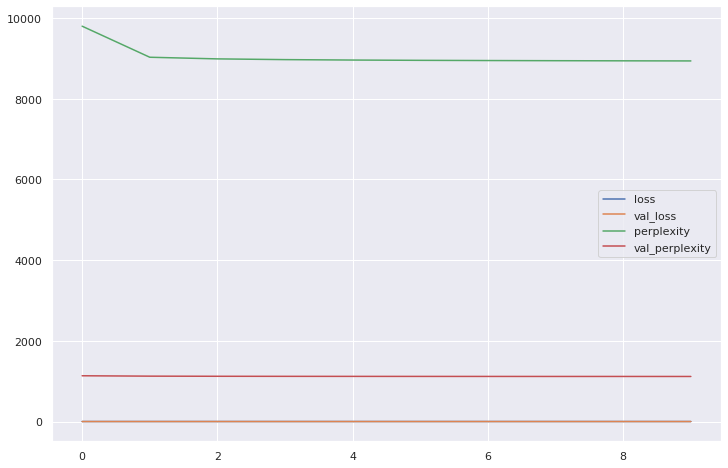

In [13]:
# train
train_evaluate_model(
    model,
    encoded_dataset,
    "char_encode_gru_lm",
    batch_size=25,
    do_test=False,
)

In [12]:
#
# 2.2 truncated BPTT - truncated-character-sequence-batch
#

In [18]:
def encode_dataset_in_batched_truncated_padded_clips_in_char(
    tokenised_content, encoder, batch_size=100, sequence_length=100
):
    encoded_clips = [
        [
            encoded
            for sentence in clip
            for encoded in [
                encoder["_BOS_"],
                *[encoder[char] for char in " ".join(sentence)],
                encoder["_EOS_"],
                encoder[" "],
            ]
        ]
        for clip in tqdm(tokenised_content)
    ]

    batch_truncated = batch_pad_truncate_dataset(
        encoded_clips, batch_size=batch_size, truncate_length=sequence_length + 1
    )

    output = [(clip[:-1], clip[1:]) for clip in batch_truncated]

    return output


SEQUENCE_LENGTH = 200
char_batch_size = 200
encoded_dataset = encode_dataset_in_batched_truncated_padded_clips_in_char(
    tokenised_content, encoder, char_batch_size, SEQUENCE_LENGTH
)
print(np.array(encoded_dataset).shape)
print("".join([decoder[n] for n in encoded_dataset[0][0]]))

100%|██████████| 10/10 [00:00<00:00, 85.89it/s]


(342000, 2, 200)
here are two reasons companies fail they only do more of the same or they only do what s new. to me the real real solution to quality growth is figuring out the balance between two activities explor


In [14]:
# stateful GRU feeding in truncated char sequences

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(
            len(encoder),
            EMBEDDING_SIZE,
            batch_input_shape=[char_batch_size, SEQUENCE_LENGTH],
        ),
        layers.GRU(
            64,
            return_sequences=True,
            stateful=True,
            recurrent_initializer="glorot_uniform",
        ),
        layers.Dense(len(decoder)),
    ]
)


def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )


model.compile(loss=loss, optimizer="adam", metrics=[Perplexity()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (2000, 200, 100)          4000      
_________________________________________________________________
gru (GRU)                    (2000, 200, 64)           31872     
_________________________________________________________________
dense (Dense)                (2000, 200, 40)           2600      
Total params: 38,472
Trainable params: 38,472
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_sample_model_output(model, decoder, test_set[0][:char_batch_size], input_char=True)

Train on 256000 samples, validate on 32000 samples
Epoch 1/10
256000/256000 [==============================] - 18s 71us/sample - loss: 1.0804 - perplexity: 1282.4790 - val_loss: 2.4862 - val_perplexity: 263.3519
Epoch 2/10
256000/256000 [==============================] - 15s 59us/sample - loss: 0.5443 - perplexity: 541.5726 - val_loss: 2.3589 - val_perplexity: 226.7833
Epoch 3/10
256000/256000 [==============================] - 15s 58us/sample - loss: 0.4954 - perplexity: 449.6806 - val_loss: 2.1188 - val_perplexity: 171.2131
Epoch 4/10
256000/256000 [==============================] - 15s 58us/sample - loss: 0.4493 - perplexity: 375.1953 - val_loss: 1.9861 - val_perplexity: 146.7169
Epoch 5/10
256000/256000 [==============================] - 15s 58us/sample - loss: 0.4245 - perplexity: 342.3530 - val_loss: 1.8961 - val_perplexity: 132.1098
Epoch 6/10
256000/256000 [==============================] - 15s 59us/sample - loss: 0.4063 - perplexity: 320.6037 - val_loss: 1.8320 - val_perplexit

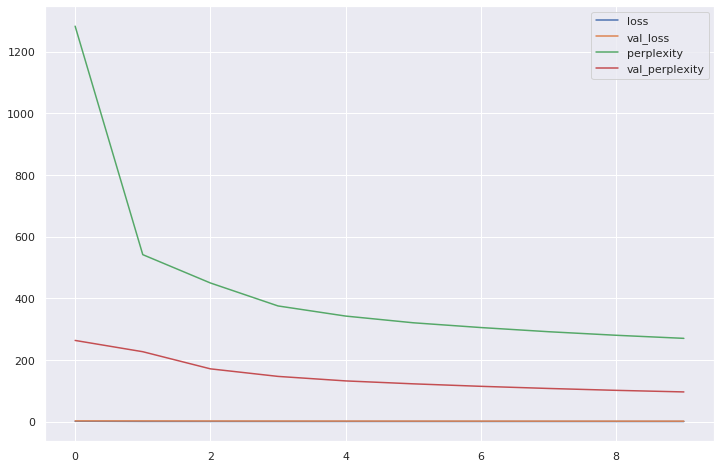

In [15]:
train_evaluate_model(
    model,
    encoded_dataset,
    "truncate_char_gru_lm",
    batch_size=char_batch_size,
    shuffle_dataset=False,
)

In [16]:
# stateful LSTM feeding in truncated word sequences

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(
            len(encoder),
            EMBEDDING_SIZE,
            batch_input_shape=[char_batch_size, SEQUENCE_LENGTH],
        ),
        layers.LSTM(
            64,
            return_sequences=True,
            stateful=True,
            recurrent_initializer="glorot_uniform",
        ),
        layers.Dense(len(decoder)),
    ]
)


def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )


model.compile(loss=loss, optimizer="adam", metrics=[Perplexity()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (2000, 200, 100)          4000      
_________________________________________________________________
lstm (LSTM)                  (2000, 200, 64)           42240     
_________________________________________________________________
dense (Dense)                (2000, 200, 40)           2600      
Total params: 48,840
Trainable params: 48,840
Non-trainable params: 0
_________________________________________________________________
None


Train on 256000 samples, validate on 32000 samples
Epoch 1/10
256000/256000 [==============================] - 17s 67us/sample - loss: 1.0067 - perplexity: 1562.2709 - val_loss: 2.5140 - val_perplexity: 272.1346
Epoch 2/10
256000/256000 [==============================] - 16s 61us/sample - loss: 0.5512 - perplexity: 561.7679 - val_loss: 2.4278 - val_perplexity: 246.0629
Epoch 3/10
256000/256000 [==============================] - 15s 60us/sample - loss: 0.5248 - perplexity: 509.1331 - val_loss: 2.2976 - val_perplexity: 211.1619
Epoch 4/10
256000/256000 [==============================] - 16s 63us/sample - loss: 0.4887 - perplexity: 439.4398 - val_loss: 2.1474 - val_perplexity: 177.1473
Epoch 5/10
256000/256000 [==============================] - 15s 60us/sample - loss: 0.4562 - perplexity: 386.3248 - val_loss: 2.0235 - val_perplexity: 153.3320
Epoch 6/10
256000/256000 [==============================] - 15s 60us/sample - loss: 0.4342 - perplexity: 355.0406 - val_loss: 1.9534 - val_perplexit

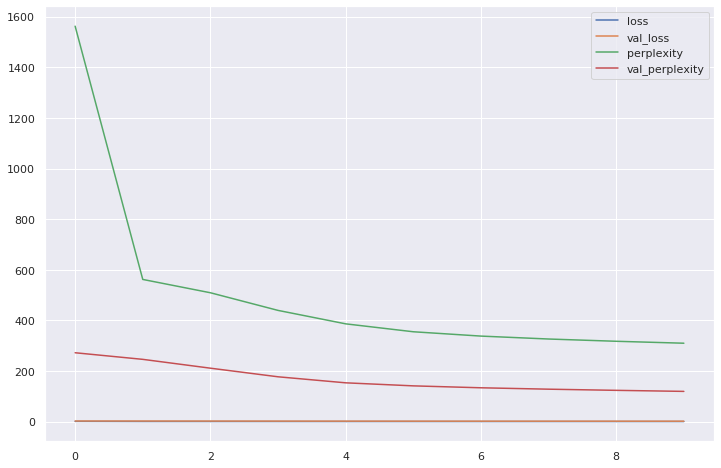

In [17]:
train_evaluate_model(
    model,
    encoded_dataset,
    "truncate_char_lstm_lm",
    batch_size=char_batch_size,
    shuffle_dataset=False,
)

In [ ]:
# Q&A

# Question 1: If you change the preprocessing of your corpus(e.g., you turn more words in UNK or you lowercase 
# everything), is perplexity still comparable?
#
# No.
# 
# Perplexity is used to model the possible options of a sequence(sentence) normalised by number of steps(words). 
# It equals to the exponential of the mean cross entropy of each step from the observed event in the sequence. 
# It can also be interpretted as the average information of on each step of the sequence, so in theory per-word perplexity
# should be smaller than the size of the vocabulary. When the corpus is shrinked, the upperbound of perplexity is shrinked as well.
#
# When calculating the cross_entropy at each step, we take -1/N*∑(pi)*log(qi). Because shrinking the encoder corpus is 
# effectively squeezing the representative true probability distribution, the average probability is raised, therefore
# -log(qi) is smaller, so is the averaged cross-entropy and perplexity.
#
# In summary, when shrinking the corpus, the perplexity is naturally shrinked, though it still reflects the averaged
# possible options of the sequence normalised per word, but it is not evaluating the language model on the same pre-condition,
# i.e. the average possible options don't represent the same amount of information.
# Therefore, they are not comparable.
#
# However, it should be possible to further normalise the perplexity against the size of the categories(vocabulary).
# Here the units of token are the same, just per unit information is different, meaning the 'UNK' token can potentially
# mean another 50000 options. A naive way to normalise this is simply adding the vocabulary difference to the perplexity
# based on the smaller vocabulary. In the practical example, the model based on top 1000 words with held-out perplexity
# of 1174, should be normalised by adding 51951 = 53125, to be compared with held-out perplexity of 1486 produced by
# the model based on the full vocabulary of 52951 words. As in the first model, there're 51951 options that are simply
# not learnt, meaning the model doesn't have the capability to distinguish them. To be more concise, the probability
# of the 'UNK' should be factor in the adding.


# Question 2: To make training tractable you can either treat sentences as i.i.d. or you can use truncated BPTT. 
# Is the i.i.d. assumption valid? What are the benefits and downsides of making this assumptions vs. truncated BPTT? 
# How do you think perplexities will compare on the held-out test set? (If you’re feeling adventurous, try it out!)
#
# Independent and Identically Distributed assumption isn't completely valid here, as due to the nature of grammar,
# there're natural sequential probability relationship between words in different sentences. Making this assumptions 
# would ignore those inter-sentence relationships. Using truncated BPTT can factor in those relationships. 
#
# Benefits of i.i.d:
# 1) easier to preprocessing the data by simply cut down content into padded sentences 
# v.s. truncate down sentences to fixed length and batch them so that each position in next batch is following the original content
# 2) more straight-forward in the model implementation, no need for stateful, and easier to batch
# 3) potentially generalised better, as the inter-sentence context can be quite domain specific given a limited dataset
#
# Downsides of i.i.d:
# 1) slower to train due to the paddings added to every sentence to normalise them to the max length for batching, 
# which doesn't contain much useful information to be learnt 
# (pre-processed to 242430samples*163tokens vs 137280samples*100tokens) -> (700s/epoch vs 240s/epoch)
# 2) depends on the needs of the language model, this factored in shorter-range dependency than truncated BPTT, 
# constrained to the length of sentence
# v.s. factoring in longer-term dependencies as far as truncate_length * num_batch
#
# Based on the implementation result, perplexity on held-out test is higher for truncated BPTT. This can be interpretted
# as that because it is trying to factor in more contextual information, therefore more factors added more uncertainty 
# to the sequence; Also it takes more data to train as well (it is hard to say truncated BPTT would produce a less accurate
# language model if training data is abundant)



# Question 3: Rather than modeling documents as a sequence of words, you can model the document as a sequence of 
# characters. Are the per-word perplexities comparable between these two models? What benefits does modeling text at 
# the character level have? What disadvantages?
#
# No. Firstly, it is probably more accurate to call it per-step/token perplexity as one learns character probability and 
# the other word; The perplexity/cross-entropy is evaluated based on a different true probability distribution, similiar
# to question 1, they are not comparable. In fact, due to the smaller corpus, perplexity is significantly smaller for
# character-based encoding. 
#
# However, it is possible to roughly normalise the per-character perplexity to per-word perplexity
# by doing ppc^(average length of word). Based on the length of samples in the practical, we can take average length
# of word as 5 characters, thus the per-character perplexity of model 2.2 of 110 should be normalised to 110^5(much larger),
# to be compared with the per-word perplexity of model 1.2 of 8466.
#
#
# 
# Pros:
# - generalise better to word not existing in the dataset vocabulary as encoded in character level
# - faster to train as the index size of the embedding layers is about 1600 times smaller(50000 vs 30)
#   equals to the length of encoder, while num_inputs = 10979*2000 vs 137280*100 increases only around 2~3 times.
#   in truncated BPTT case, 20s/epoch vs 240s/epoch
#
# Cons:
# - information of the pre-knowledge of word is formed by characters is not present in the model initially, which needs
#  to be learnt; when insufficiently trained, the model is likely to output word that does not exist in actual vocabulary
# - it requires more data to be trained properly?


# Question 4: Try a couple variations of the model using different definitions of RNNs (e.g., LSTMs, GRUs, simple 
# Elman RNNs) that were covered in class. How do perplexities compare?
#
# GRU performs better than LSTM due to the limited availability of data, and foreably better than vanilla RNN.


# Question 5: In text classification, using bidirectional RNNs was suggested, could you use bidirectional RNNs for 
# the language modeling task? Why or why not?
# 
# Yes.
# 
# Practically, when not using truncated BPTT with stateful RNNs, it is possible to using BRNN assuming i.i.d.
# In this case, the network will add a reversed layer of RNN, feeding reversed (output,input) to gain a model
# that is also able to predict sequence backwards. When using together, the forward and backward network is merged
# via chosen method, e.g. concat, to be forwarded to the output Dense layer to produce logits for sampling.
#
# In the example models of 1.1, BRNN shows better perplexity than unidirectional RNN.